In [2]:
%load_ext autoreload
%autoreload 2

In [243]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import pandas as pd

from helper_functions import euclidean_distance
from helper_functions import contrastive_loss
from helper_functions import load_arrays
from helper_functions import plot_training
from helper_functions import load_and_split_data
from helper_functions import plot_confusion_matrix
from helper_functions import get_model_predictions
from helper_functions import plot_roc_curve
from helper_functions import plot_prec_rec_curve
from helper_functions import recall_f
from helper_functions import precision_f
from helper_functions import f1
from helper_functions import evaluate_preds

# Load and prepare Data

### Load and create fast input pipeline with tf.data.dataset

In [3]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_10000.npz", "npz_datasets/data_y_10000.npz", split_size=80, batch_size=256)

CPU times: user 11.8 s, sys: 2.88 s, total: 14.7 s
Wall time: 14.7 s


In [4]:
%%time
train_dataset_rgb, test_dataset_rgb, val_dataset_rgb = load_and_split_data("npz_datasets/data_x_15000_rgb.npz", "npz_datasets/data_y_15000_rgb.npz", split_size=80, batch_size=256)

CPU times: user 53.3 s, sys: 13.3 s, total: 1min 6s
Wall time: 1min 6s


# Baseline Model

In [30]:
img_width = 224
img_height = 224

In [31]:
#Set seed
tf.random.set_seed(42)

#Build the model
inputs = keras.layers.Input((img_width, img_height, 1))

x = keras.layers.Conv2D(4, (3,3), activation="relu")(inputs)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(16, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Conv2D(32, (3,3), activation="relu")(x)
x = keras.layers.MaxPool2D(3,3)(x)

x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(48, activation="relu")(x)

base_model_1 = keras.models.Model(inputs, outputs)

In [32]:
base_model_1.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 4)       40        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 4)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 16)        592       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0   

In [33]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_1(img_a)
feat_vect_b = base_model_1(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [34]:
#Compile the model 
model_1 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_1.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [35]:
epochs=20
history_model_1 = model_1.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/20
32/32 [==============================] - 7s 208ms/step - loss: 0.3094 - accuracy: 0.4832 - val_loss: 0.2910 - val_accuracy: 0.4675
Epoch 2/20
32/32 [==============================] - 6s 204ms/step - loss: 0.2679 - accuracy: 0.5070 - val_loss: 0.2732 - val_accuracy: 0.4819
Epoch 3/20
32/32 [==============================] - 6s 203ms/step - loss: 0.2543 - accuracy: 0.5341 - val_loss: 0.2696 - val_accuracy: 0.4794
Epoch 4/20
32/32 [==============================] - 6s 203ms/step - loss: 0.2463 - accuracy: 0.5594 - val_loss: 0.2671 - val_accuracy: 0.4875
Epoch 5/20
32/32 [==============================] - 6s 204ms/step - loss: 0.2389 - accuracy: 0.5861 - val_loss: 0.2672 - val_accuracy: 0.4969
Epoch 6/20
32/32 [==============================] - 7s 205ms/step - loss: 0.2318 - accuracy: 0.6115 - val_loss: 0.2668 - val_accuracy: 0.4969
Epoch 7/20
32/32 [==============================] - 7s 205ms/step - loss: 0.2249 - accuracy: 0.6403 - val_loss: 0.2682 - val_accuracy: 0.4950
Epoch 

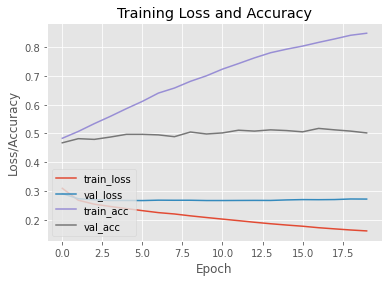

In [36]:
plot_training(history_model_1)

# Evaluate the model

In [37]:
model_1.evaluate(val_dataset)

2/2 [==============================] - 0s 81ms/step - loss: 0.2797 - accuracy: 0.4925


[0.2797412574291229, 0.4925000071525574]

# EfficientNetB0

In [179]:
img_width = 224
img_height = 224

In [180]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(256, activation="relu")(x)

base_model_efficientnet_b0 = keras.models.Model(inputs, outputs)

In [181]:
base_model_efficientnet_b0.summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_18  (None, 1280)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)               131328    
Total params: 4,836,771
Trainable params: 787,200
Non-trainable params: 4,049,571
__________________________________________

In [182]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_efficientnet_b0(img_a)
feat_vect_b = base_model_efficientnet_b0(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [183]:
#Compile the model 
model_efficientnet_b0 = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_efficientnet_b0.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy", f1, precision_f, recall_f])

In [184]:
epochs=10
history_model_efficientnet_b0 = model_efficientnet_b0.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs)

Epoch 1/10
47/47 [==============================] - 45s 843ms/step - loss: 0.2510 - accuracy: 0.4949 - f1: 0.4165 - precision_f: 0.3923 - recall_f: 0.5138 - val_loss: 0.2500 - val_accuracy: 0.5071 - val_f1: 0.0000e+00 - val_precision_f: 0.0000e+00 - val_recall_f: 0.0000e+00
Epoch 2/10
47/47 [==============================] - 38s 811ms/step - loss: 0.2500 - accuracy: 0.4958 - f1: 0.0458 - precision_f: 0.0875 - recall_f: 0.0313 - val_loss: 0.2500 - val_accuracy: 0.5071 - val_f1: 0.0000e+00 - val_precision_f: 0.0000e+00 - val_recall_f: 0.0000e+00
Epoch 3/10
47/47 [==============================] - 38s 809ms/step - loss: 0.2500 - accuracy: 0.4987 - f1: 0.0000e+00 - precision_f: 0.0000e+00 - recall_f: 0.0000e+00 - val_loss: 0.2500 - val_accuracy: 0.5071 - val_f1: 0.0000e+00 - val_precision_f: 0.0000e+00 - val_recall_f: 0.0000e+00
Epoch 4/10
47/47 [==============================] - 38s 811ms/step - loss: 0.2500 - accuracy: 0.4987 - f1: 0.0000e+00 - precision_f: 0.0000e+00 - recall_f: 0.0000e

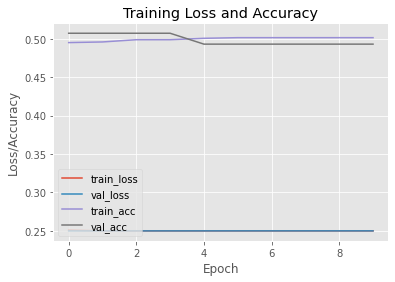

In [185]:
plot_training(history_model_efficientnet_b0)

In [186]:
efficientnet_b0_results = evaluate_preds(model_efficientnet_b0, val_dataset_rgb)

3/3 [==============================] - 2s 421ms/step - loss: 0.2500 - accuracy: 0.5017 - f1: 0.6759 - precision_f: 0.5112 - recall_f: 1.0000


# VGG 16

In [187]:
img_width = 224
img_height = 224

In [188]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.vgg16.VGG16(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(256, activation="relu")(x)

base_model_vgg_16 = keras.models.Model(inputs, outputs)

In [189]:
base_model_vgg_16.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_19  (None, 512)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 256)               131328    
Total params: 15,108,672
Trainable params: 393,984
Non-trainable params: 14,714,688
________________________________________

In [190]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_vgg_16(img_a)
feat_vect_b = base_model_vgg_16(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [191]:
#Compile the model 
model_vgg_16 = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_vgg_16.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy", f1, precision_f, recall_f])

In [192]:
epochs=10
history_model_vgg_16 = model_vgg_16.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs, 
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=15), 
                                       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=5)])

Epoch 1/10
47/47 [==============================] - 48s 1s/step - loss: 0.2528 - accuracy: 0.4987 - f1: 0.0000e+00 - precision_f: 0.0000e+00 - recall_f: 0.0000e+00 - val_loss: 0.2425 - val_accuracy: 0.5071 - val_f1: 0.0016 - val_precision_f: 0.1000 - val_recall_f: 7.9365e-04
Epoch 2/10
47/47 [==============================] - 47s 1s/step - loss: 0.2412 - accuracy: 0.5072 - f1: 0.0413 - precision_f: 0.4329 - recall_f: 0.0225 - val_loss: 0.2351 - val_accuracy: 0.5575 - val_f1: 0.3199 - val_precision_f: 0.6605 - val_recall_f: 0.2126
Epoch 3/10
47/47 [==============================] - 47s 1s/step - loss: 0.2354 - accuracy: 0.5512 - f1: 0.2876 - precision_f: 0.6924 - recall_f: 0.1881 - val_loss: 0.2311 - val_accuracy: 0.5846 - val_f1: 0.4544 - val_precision_f: 0.6608 - val_recall_f: 0.3488
Epoch 4/10
47/47 [==============================] - 47s 1s/step - loss: 0.2313 - accuracy: 0.5834 - f1: 0.4367 - precision_f: 0.6750 - recall_f: 0.3253 - val_loss: 0.2275 - val_accuracy: 0.6100 - val_f1: 

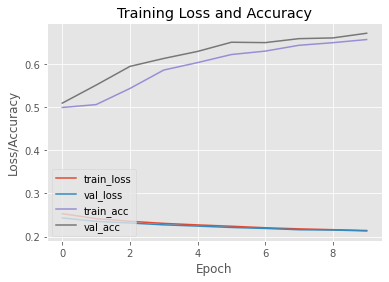

In [193]:
plot_training(history_model_3)

In [194]:
vgg16_results = evaluate_preds(model_vgg_16, val_dataset_rgb)

3/3 [==============================] - 3s 541ms/step - loss: 0.2236 - accuracy: 0.6300 - f1: 0.6421 - precision_f: 0.6187 - recall_f: 0.6683


# VGG 19

In [195]:
img_width = 224
img_height = 224

In [196]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.vgg19.VGG19(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(256, activation="relu")(x)

base_model_vgg_19 = keras.models.Model(inputs, outputs)

In [197]:
base_model_vgg_19.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d_20  (None, 512)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 256)               131328    
Total params: 20,418,368
Trainable params: 393,984
Non-trainable params: 20,024,384
________________________________________

In [198]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_vgg_19(img_a)
feat_vect_b = base_model_vgg_19(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [199]:
#Compile the model 
model_vgg_19 = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_vgg_19.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy", f1, precision_f, recall_f])

In [200]:
epochs=10
history_model_vgg_19 = model_vgg_19.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs, 
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=15), 
                                       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=5)])

Epoch 1/10
47/47 [==============================] - 52s 1s/step - loss: 0.2786 - accuracy: 0.4933 - f1: 0.5866 - precision_f: 0.4977 - recall_f: 0.7969 - val_loss: 0.2506 - val_accuracy: 0.4796 - val_f1: 0.6273 - val_precision_f: 0.4884 - val_recall_f: 0.8792
Epoch 2/10
47/47 [==============================] - 51s 1s/step - loss: 0.2503 - accuracy: 0.4918 - f1: 0.2949 - precision_f: 0.4864 - recall_f: 0.3173 - val_loss: 0.2502 - val_accuracy: 0.4804 - val_f1: 0.5209 - val_precision_f: 0.4831 - val_recall_f: 0.5684
Epoch 3/10
47/47 [==============================] - 51s 1s/step - loss: 0.2502 - accuracy: 0.4918 - f1: 0.1350 - precision_f: 0.1266 - recall_f: 0.1589 - val_loss: 0.2500 - val_accuracy: 0.5071 - val_f1: 0.0000e+00 - val_precision_f: 0.0000e+00 - val_recall_f: 0.0000e+00
Epoch 4/10
47/47 [==============================] - 51s 1s/step - loss: 0.2500 - accuracy: 0.4987 - f1: 0.0000e+00 - precision_f: 0.0000e+00 - recall_f: 0.0000e+00 - val_loss: 0.2500 - val_accuracy: 0.5071 - 

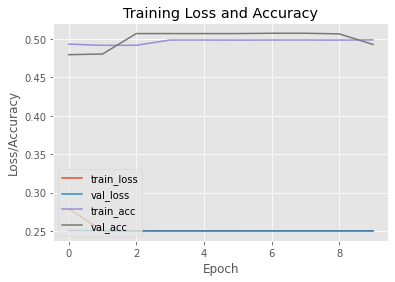

In [201]:
plot_training(history_model_vgg_19)

In [202]:
vgg19_results = evaluate_preds(model_vgg_19, val_dataset_rgb)

3/3 [==============================] - 3s 579ms/step - loss: 0.2500 - accuracy: 0.5017 - f1: 0.6760 - precision_f: 0.5112 - recall_f: 1.0000


# Resnet 101 V2

In [203]:
img_width = 224
img_height = 224

In [204]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.resnet_v2.ResNet101V2(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(256, activation="relu")(x)

base_model_resnet_101 = keras.models.Model(inputs, outputs)

In [205]:
base_model_resnet_101.summary()

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_86 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, None, None, 2048)  42626560  
_________________________________________________________________
global_average_pooling2d_21  (None, 2048)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
Total params: 43,806,976
Trainable params: 1,180,416
Non-trainable params: 42,626,560
______________________________________

In [206]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_resnet_101(img_a)
feat_vect_b = base_model_resnet_101(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [207]:
#Compile the model 
model_resnet_101 = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_resnet_101.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy", f1, precision_f, recall_f])

In [208]:
epochs=10
history_model_resnet_101 = model_resnet_101.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs, 
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=15), 
                                       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=5)])

Epoch 1/10
47/47 [==============================] - 60s 1s/step - loss: 0.2440 - accuracy: 0.4987 - f1: 0.0000e+00 - precision_f: 0.0000e+00 - recall_f: 0.0000e+00 - val_loss: 0.2318 - val_accuracy: 0.5117 - val_f1: 0.0201 - val_precision_f: 0.7000 - val_recall_f: 0.0102
Epoch 2/10
47/47 [==============================] - 53s 1s/step - loss: 0.2305 - accuracy: 0.5247 - f1: 0.1404 - precision_f: 0.5669 - recall_f: 0.0871 - val_loss: 0.2250 - val_accuracy: 0.5788 - val_f1: 0.3958 - val_precision_f: 0.6647 - val_recall_f: 0.2846
Epoch 3/10
47/47 [==============================] - 53s 1s/step - loss: 0.2232 - accuracy: 0.5936 - f1: 0.4663 - precision_f: 0.6786 - recall_f: 0.3711 - val_loss: 0.2211 - val_accuracy: 0.6129 - val_f1: 0.5408 - val_precision_f: 0.6542 - val_recall_f: 0.4626
Epoch 4/10
47/47 [==============================] - 53s 1s/step - loss: 0.2173 - accuracy: 0.6252 - f1: 0.5679 - precision_f: 0.6718 - recall_f: 0.5040 - val_loss: 0.2189 - val_accuracy: 0.6237 - val_f1: 0.60

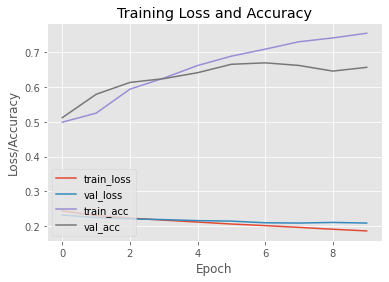

In [209]:
plot_training(history_model_resnet_101)

In [210]:
resnet_101_results = evaluate_preds(model_resnet_101, val_dataset_rgb)

3/3 [==============================] - 3s 600ms/step - loss: 0.2233 - accuracy: 0.6217 - f1: 0.5811 - precision_f: 0.6875 - recall_f: 0.5126


# Alexnet - from Scratch

In [84]:
img_width = 224
img_height = 224

In [101]:
#Set seed
tf.random.set_seed(42)

#Build the model
inputs = keras.layers.Input((img_width, img_height, 1))

x = keras.layers.Conv2D(96, (11,11), strides=4, padding="same")(inputs)
x = keras.layers.Lambda(tf.nn.local_response_normalization)(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPool2D((3,3), strides=2)(x)

x = keras.layers.Conv2D(256, (5,5), strides=4, padding="same")(x)
x = keras.layers.Lambda(tf.nn.local_response_normalization)(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPool2D((3,3), strides=2)(x)

x = keras.layers.Conv2D(384, (3,3), strides=4, padding="same")(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2D(384, (3,3), strides=4, padding="same")(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2D(256, (3,3), strides=4, padding="same")(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(4096, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(4096, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(48, activation="relu")(x)

base_model_5 = keras.models.Model(inputs, outputs)

In [102]:
base_model_5.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 56, 56, 96)        11712     
_________________________________________________________________
lambda_15 (Lambda)           (None, 56, 56, 96)        0         
_________________________________________________________________
activation_15 (Activation)   (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_16 (Lambda)           (None, 7, 7, 256)         0  

In [103]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_5(img_a)
feat_vect_b = base_model_5(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])

In [104]:
#Compile the model 
model_5 = keras.models.Model(inputs=[img_a, img_b], outputs=distance)
model_5.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [ ]:
epochs=10
history_model_5 = model_5.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=2)])

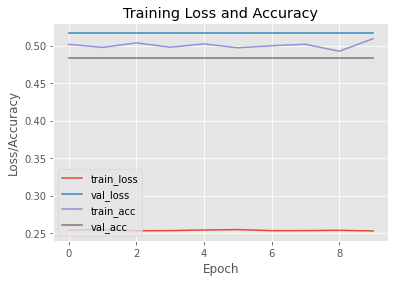

In [111]:
plot_training(history_model_5)

# Model from Scratch

In [5]:
img_width = 224
img_height = 224

In [80]:
#Set seed
tf.random.set_seed(42)

#Build the model
inputs = keras.layers.Input((img_width, img_height, 1))

x = keras.layers.Conv2D(8, (2,2), activation="relu")(inputs)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Conv2D(8, (2,2), activation="relu")(x)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Conv2D(16, (2,2), activation="relu")(x)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Conv2D(32, (2,2), activation="relu")(x)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Conv2D(64, (2,2), activation="relu")(x)
x = keras.layers.MaxPool2D(2,2)(x)

x = keras.layers.Flatten()(x)

outputs = keras.layers.Dense(128, activation="relu")(x)

base_model_6 = keras.models.Model(inputs, outputs)

In [81]:
base_model_6.summary()

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 223, 223, 8)       40        
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 111, 111, 8)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 110, 110, 8)       264       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 54, 54, 16)        528       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 27, 27, 16)        0  

In [82]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 1))
img_b = keras.layers.Input((img_width, img_height, 1))

feat_vect_a = base_model_6(img_a)
feat_vect_b = base_model_6(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [83]:
#Compile the model 
model_6 = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_6.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy"])

In [ ]:
epochs=150
history_model_6 = model_6.fit(train_dataset, validation_data=test_dataset, epochs=epochs, 
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5), 
                                       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5)])

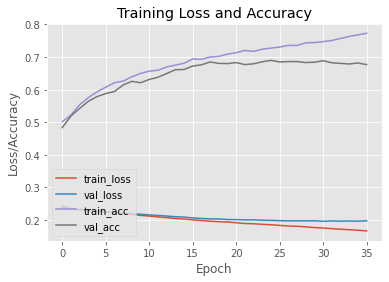

In [85]:
plot_training(history_model_6)

# InceptionResNetV2

In [211]:
img_width = 224
img_height = 224

In [212]:

#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.InceptionResNetV2(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(256, activation="relu")(x)

base_model_resnet = keras.models.Model(inputs, outputs)

In [213]:
base_model_resnet.summary()

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_90 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
global_average_pooling2d_22  (None, 1536)              0         
_________________________________________________________________
dense_68 (Dense)             (None, 512)               786944    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 256)               131328    
Total params: 55,255,008
Trainable params: 918,272
Non-trainable params: 54,336,736
________________________________________

In [214]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_resnet(img_a)
feat_vect_b = base_model_resnet(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [215]:
#Compile the model 
model_resnet = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_resnet.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy", f1, precision_f, recall_f])

In [216]:
epochs=10
history_model_resnet = model_resnet.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs, 
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=15), 
                                       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=5)])

Epoch 1/10
47/47 [==============================] - 70s 1s/step - loss: 0.2504 - accuracy: 0.5010 - f1: 0.0241 - precision_f: 0.2269 - recall_f: 0.0130 - val_loss: 0.2334 - val_accuracy: 0.5467 - val_f1: 0.2310 - val_precision_f: 0.7065 - val_recall_f: 0.1386
Epoch 2/10
47/47 [==============================] - 55s 1s/step - loss: 0.2350 - accuracy: 0.5255 - f1: 0.1837 - precision_f: 0.6755 - recall_f: 0.1120 - val_loss: 0.2291 - val_accuracy: 0.5771 - val_f1: 0.4335 - val_precision_f: 0.6327 - val_recall_f: 0.3305
Epoch 3/10
47/47 [==============================] - 55s 1s/step - loss: 0.2309 - accuracy: 0.5539 - f1: 0.3408 - precision_f: 0.6504 - recall_f: 0.2440 - val_loss: 0.2262 - val_accuracy: 0.6221 - val_f1: 0.5592 - val_precision_f: 0.6564 - val_recall_f: 0.4896
Epoch 4/10
47/47 [==============================] - 55s 1s/step - loss: 0.2259 - accuracy: 0.5874 - f1: 0.4726 - precision_f: 0.6549 - recall_f: 0.3790 - val_loss: 0.2231 - val_accuracy: 0.6350 - val_f1: 0.5978 - val_pre

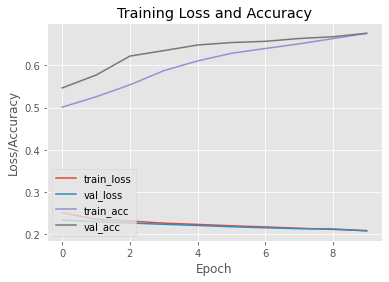

In [217]:
plot_training(history_model_resnet)

In [218]:
inception_resnet_results = evaluate_preds(model_resnet, val_dataset_rgb)

3/3 [==============================] - 3s 638ms/step - loss: 0.2205 - accuracy: 0.6217 - f1: 0.6249 - precision_f: 0.6424 - recall_f: 0.6094


# MobileNet V3 Large

In [219]:
img_width = 224
img_height = 224

In [220]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.MobileNetV3Large(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(256, activation="relu")(x)

base_model_mobilenet_v3 = keras.models.Model(inputs, outputs)

In [221]:
base_model_mobilenet_v3.summary()

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_94 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, None, None, 1280)  4226432   
_________________________________________________________________
global_average_pooling2d_23  (None, 1280)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               131328    
Total params: 5,013,632
Trainable params: 787,200
Non-trainable params: 4,226,432
__________________________________________

In [222]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_mobilenet_v3(img_a)
feat_vect_b = base_model_mobilenet_v3(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [223]:
#Compile the model 
model_mobilenet_v3 = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_mobilenet_v3.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy", f1, precision_f, recall_f])

In [224]:
epochs=10
history_model_mobilenet_v3 = model_mobilenet_v3.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs, 
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=15), 
                                       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=5)])

Epoch 1/10
47/47 [==============================] - 37s 708ms/step - loss: 0.2517 - accuracy: 0.5183 - f1: 0.4192 - precision_f: 0.4276 - recall_f: 0.5043 - val_loss: 0.2495 - val_accuracy: 0.5754 - val_f1: 0.6915 - val_precision_f: 0.5437 - val_recall_f: 0.9513
Epoch 2/10
47/47 [==============================] - 32s 681ms/step - loss: 0.2493 - accuracy: 0.5640 - f1: 0.5527 - precision_f: 0.5720 - recall_f: 0.5517 - val_loss: 0.2493 - val_accuracy: 0.5763 - val_f1: 0.6437 - val_precision_f: 0.5503 - val_recall_f: 0.7776
Epoch 3/10
47/47 [==============================] - 32s 682ms/step - loss: 0.2500 - accuracy: 0.5014 - f1: 0.6658 - precision_f: 0.5018 - recall_f: 0.9943 - val_loss: 0.2501 - val_accuracy: 0.4929 - val_f1: 0.6641 - val_precision_f: 0.4979 - val_recall_f: 1.0000
Epoch 4/10
47/47 [==============================] - 32s 681ms/step - loss: 0.2500 - accuracy: 0.5013 - f1: 0.6674 - precision_f: 0.5014 - recall_f: 1.0000 - val_loss: 0.2501 - val_accuracy: 0.4929 - val_f1: 0.65

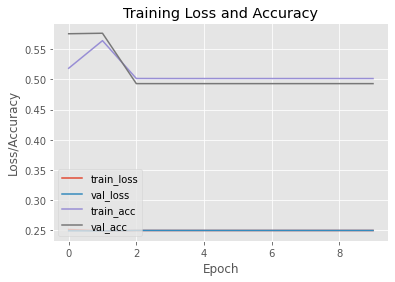

In [225]:
plot_training(history_model_mobilenet_v3)

In [226]:
mobilenet_v3_results = evaluate_preds(model_mobilenet_v3, val_dataset_rgb)

3/3 [==============================] - 2s 340ms/step - loss: 0.2500 - accuracy: 0.5017 - f1: 0.6779 - precision_f: 0.5137 - recall_f: 1.0000


# Xception

In [227]:
img_width = 224
img_height = 224

In [228]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.xception.Xception(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(256, activation="relu")(x)

base_model_xception = keras.models.Model(inputs, outputs)

In [229]:
base_model_xception.summary()

Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_98 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_24  (None, 2048)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               131328    
Total params: 22,041,896
Trainable params: 1,180,416
Non-trainable params: 20,861,480
______________________________________

In [230]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_xception(img_a)
feat_vect_b = base_model_xception(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [231]:
#Compile the model 
model_xception = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_xception.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy", f1, precision_f, recall_f])

In [232]:
epochs=10
history_model_xception = model_xception.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs, 
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=15), 
                                       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=5)])

Epoch 1/10
47/47 [==============================] - 49s 995ms/step - loss: 0.2470 - accuracy: 0.4988 - f1: 0.0030 - precision_f: 0.1078 - recall_f: 0.0015 - val_loss: 0.2392 - val_accuracy: 0.5225 - val_f1: 0.1686 - val_precision_f: 0.5904 - val_recall_f: 0.0997
Epoch 2/10
47/47 [==============================] - 46s 977ms/step - loss: 0.2371 - accuracy: 0.5225 - f1: 0.1487 - precision_f: 0.7134 - recall_f: 0.0868 - val_loss: 0.2325 - val_accuracy: 0.5612 - val_f1: 0.3681 - val_precision_f: 0.6138 - val_recall_f: 0.2650
Epoch 3/10
47/47 [==============================] - 46s 979ms/step - loss: 0.2312 - accuracy: 0.5723 - f1: 0.3772 - precision_f: 0.7004 - recall_f: 0.2671 - val_loss: 0.2293 - val_accuracy: 0.5804 - val_f1: 0.4441 - val_precision_f: 0.6272 - val_recall_f: 0.3444
Epoch 4/10
47/47 [==============================] - 46s 979ms/step - loss: 0.2264 - accuracy: 0.5985 - f1: 0.4815 - precision_f: 0.6839 - recall_f: 0.3777 - val_loss: 0.2267 - val_accuracy: 0.5954 - val_f1: 0.51

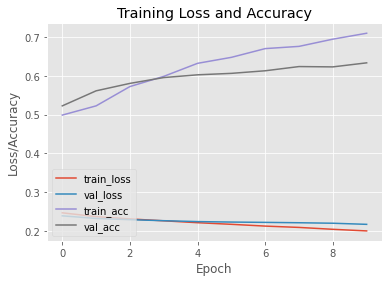

In [233]:
plot_training(history_model_xception)

In [234]:
xception_results = evaluate_preds(model_xception, val_dataset_rgb)

3/3 [==============================] - 3s 515ms/step - loss: 0.2256 - accuracy: 0.6100 - f1: 0.5862 - precision_f: 0.6117 - recall_f: 0.5635


# Inception V3

In [235]:
img_width = 224
img_height = 224

In [236]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(256, activation="relu")(x)

base_model_inception_v3 = keras.models.Model(inputs, outputs)

In [237]:
base_model_inception_v3.summary()

Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_102 (InputLayer)       [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d_25  (None, 2048)              0         
_________________________________________________________________
dense_77 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 256)               131328    
Total params: 22,983,200
Trainable params: 1,180,416
Non-trainable params: 21,802,784
______________________________________

In [238]:
#define inputs and ouputs
img_a = keras.layers.Input((img_width, img_height, 3))
img_b = keras.layers.Input((img_width, img_height, 3))

feat_vect_a = base_model_inception_v3(img_a)
feat_vect_b = base_model_inception_v3(img_b)

distance = keras.layers.Lambda(euclidean_distance)([feat_vect_a, feat_vect_b])
outputs = keras.layers.Dense(1, activation="sigmoid")(distance)

In [239]:
#Compile the model 
model_inception_v3 = keras.models.Model(inputs=[img_a, img_b], outputs=outputs)
model_inception_v3.compile(loss=contrastive_loss, optimizer="Adam", metrics=["accuracy", f1, precision_f, recall_f])

In [240]:
epochs=10
history_model_inception_v3 = model_inception_v3.fit(train_dataset_rgb, validation_data=test_dataset_rgb, epochs=epochs, 
                             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=15), 
                                       keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=5)])

Epoch 1/10
47/47 [==============================] - 42s 810ms/step - loss: 0.2775 - accuracy: 0.5102 - f1: 0.3464 - precision_f: 0.3508 - recall_f: 0.3897 - val_loss: 0.2501 - val_accuracy: 0.5029 - val_f1: 0.6326 - val_precision_f: 0.4957 - val_recall_f: 0.8761
Epoch 2/10
47/47 [==============================] - 36s 780ms/step - loss: 0.2500 - accuracy: 0.5056 - f1: 0.6247 - precision_f: 0.5040 - recall_f: 0.8745 - val_loss: 0.2501 - val_accuracy: 0.4929 - val_f1: 0.6641 - val_precision_f: 0.4986 - val_recall_f: 1.0000
Epoch 3/10
47/47 [==============================] - 36s 778ms/step - loss: 0.2500 - accuracy: 0.5010 - f1: 0.6664 - precision_f: 0.5012 - recall_f: 0.9964 - val_loss: 0.2501 - val_accuracy: 0.4929 - val_f1: 0.6631 - val_precision_f: 0.4973 - val_recall_f: 1.0000
Epoch 4/10
47/47 [==============================] - 36s 779ms/step - loss: 0.2500 - accuracy: 0.5013 - f1: 0.6675 - precision_f: 0.5014 - recall_f: 0.9997 - val_loss: 0.2501 - val_accuracy: 0.4929 - val_f1: 0.65

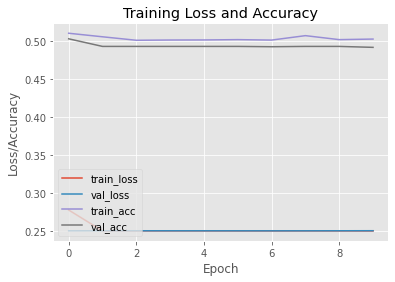

In [241]:
plot_training(history_model_inception_v3)

In [242]:
inception_v3_results = evaluate_preds(model_inception_v3, val_dataset_rgb)

3/3 [==============================] - 2s 414ms/step - loss: 0.2496 - accuracy: 0.5033 - f1: 0.6735 - precision_f: 0.5122 - recall_f: 0.9851


# Model comparison

In [246]:
model_results = pd.DataFrame({"EfficientNetB0": efficientnet_b0_results,
                              "VGG16": vgg16_results,
                              "VGG19": vgg19_results,
                              "Resnet 101 V2": resnet_101_results,
                              "Inception Resnet V2": inception_resnet_results,
                              "MobileNet V3 Large": mobilenet_v3_results,
                              "Xcpetion": xception_results,
                              "Inception V3": inception_v3_results
}).T

In [248]:
model_results.sort_values(by="accuracy")

,loss,accuracy,f1-score,precision,recall
EfficientNetB0,0.249997,0.501667,0.675909,0.511245,1.000000
VGG19,0.250000,0.501667,0.675995,0.511245,1.000000
MobileNet V3 Large,0.249997,0.501667,0.677933,0.513731,1.000000
Inception V3,0.249595,0.503333,0.673529,0.512189,0.985095
Xcpetion,0.225565,0.610000,0.586169,0.611699,0.563531
Resnet 101 V2,0.223314,0.621667,0.581072,0.687549,0.512559
Inception Resnet V2,0.220454,0.621667,0.624908,0.642437,0.609410
VGG16,0.223556,0.630000,0.642112,0.618743,0.668314
